In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from nn_model import NNModel

from spn.algorithms.Marginalization import marginalize
from spn.algorithms.Inference import log_likelihood

def get_related(index, data_name):
    for i in range(5):
        testdata = pd.read_csv(f"{path_base}/{data_name}/{i}/data/X_subtest.csv", index_col=0)
        if index in testdata.index:
            with open(f"{path_base}/{data_name}/{i}/models/spn.pickle", "rb") as f:
                spn = pickle.load(f)
            with open(f"{path_base}/{data_name}/{i}/models/dhandler.pickle", "rb") as f:
                dhandler = pickle.load(f)
            nn = NNModel(dhandler.encoding_width(True), [20, 10], 1)
            nn.load(f"{path_base}/{data_name}/{i}/models/nn.pt")
            break
    return spn, dhandler, testdata.loc[index], i, nn


def get_bounds(feat):
    bound_edits = {
        "Credit amount": (0, -8500),
        "Duration": (0, -30),
    }
    if hasattr(feat, "bounds"):
        min, max = feat.bounds
    elif hasattr(feat, "numeric_vals"):
        min, max = feat.numeric_vals[0], feat.numeric_vals[-1]
        return min, max+1, feat.numeric_vals, 0.5

    if feat.name in bound_edits:
        min += bound_edits[feat.name][0]
        max += bound_edits[feat.name][1]
    if feat.discrete:
        return min, max, np.arange(min, max+1), 0
    return min, max, np.linspace(min, max, 1000), 0


path_base = "results/real_data"

with open(path_base + "/results.pickle", "rb") as f:
    smaller_results = pickle.load(f)


data_names = ["credit", "adult", "gmsc"]

results = {}
for data_name in data_names:
    results[data_name] = {
        "LiCE_optimize": smaller_results[data_name]["LiCE_optimize"],
        "LiCE_median": smaller_results[data_name]["LiCE_median"],
        "LiCE_quartile": smaller_results[data_name]["LiCE_quartile"],
        "LiCE_sample": smaller_results[data_name]["LiCE_sample"],
        "MIO + SPN": smaller_results[data_name]["MIO_no_spn"],
        "VAE + SPN": smaller_results[data_name]["VAE"],
        "DiCE + SPN": smaller_results[data_name]["DiCE"],
        "CH-CVAE ": smaller_results[data_name]["CVAE"],
        "FACE_knn": smaller_results[data_name]["FACE_knn"],
        "FACE_eps": smaller_results[data_name]["FACE_eps"],
        "PROPLACE": smaller_results[data_name]["PROPLACE"],
    }


Predicted [False]
LiCE_median 1 ['Installment rate in percentage of disposable income'] [4] [2.809594]
MIO + SPN 3 ['Duration' 'Installment rate in percentage of disposable income' 'Age'] [36 4 30] [35.0 2.951445 31.0]
PROPLACE 8 ['Status of existing checking account' 'Duration' 'Purpose'
 'Credit amount' 'Savings account/bonds' 'Present residence since' 'Age'
 'Number of people being liable to provide maintenance for'] ['A11' 36 'A42' 3959 'A61' 3 30 1] ['A14' 6.0 'A48' 1238.00006812 'A65' 4.0 36.0 2.0]
FACE_eps 8 ['Status of existing checking account' 'Duration' 'Credit history'
 'Credit amount' 'Installment rate in percentage of disposable income'
 'Personal status and sex' 'Present residence since' 'Age'] ['A11' 36 'A32' 3959 4 'A93' 3 30] ['A12' 24.0 'A33' 2064.0 3.0 'A92' 2.0 34.0]
FACE_knn 7 ['Duration' 'Purpose' 'Credit amount' 'Present residence since' 'Property'
 'Age' 'Housing'] [36 'A42' 3959 3 'A122' 30 'A152'] [24.0 'A41' 6579.0 2.0 'A124' 29.0 'A153']
CH-CVAE  5 ['Durati

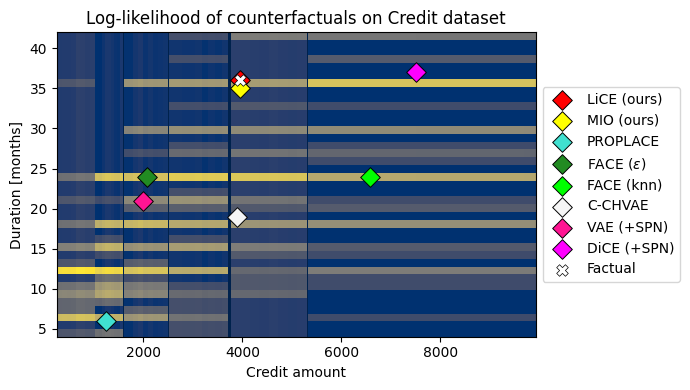

In [2]:
shown_folds = []
data_name = "credit"
fact_i = 993

testdata = pd.read_csv(f"{path_base}/{data_name}/0/data/X_subtest.csv", index_col=0)
spn, dhandler, factual, fold, nn = get_related(fact_i, data_name)
print("Predicted", nn.predict(dhandler.encode(factual)) > 0)

x_i, y_i = 4, 1

feat_x = dhandler.features[x_i]
feat_y = dhandler.features[y_i]


minx, maxx, x, shiftx = get_bounds(feat_x)
miny, maxy, y, shifty = get_bounds(feat_y)


X, Y = np.meshgrid(x, y)
flatX = X.flatten()
flatY = Y.flatten()

marginal_spn = marginalize(spn.spn_model, [x_i, y_i])
custom_data = np.zeros((flatX.shape[0], dhandler.n_features))
custom_data[:,x_i] = flatX
custom_data[:,y_i] = flatY
lls = log_likelihood(marginal_spn, custom_data, axis=1)
lls[lls<-12.5] = -12.5


plt.figure(figsize=(7,4))
plt.imshow(lls.reshape(X.shape), interpolation='none', origin="lower", aspect='auto', extent=[minx,maxx,miny,maxy], vmax=lls.max(), vmin=lls.min(), cmap="cividis")

methods_plt = [
    ("LiCE_median", "red", "LiCE (ours)"),
    ("MIO + SPN", "yellow", "MIO (ours)"),
    ("PROPLACE", "turquoise", "PROPLACE"),
    ("FACE_eps", "forestgreen", "FACE ($\epsilon$)"),
    ("FACE_knn", "lime", "FACE (knn)"),
    ("CH-CVAE ", "whitesmoke", "C-CHVAE"),
    ("VAE + SPN", "deeppink", "VAE (+SPN)"),
    ("DiCE + SPN", "magenta", "DiCE (+SPN)"),
]
kwargs = {"marker":"D", "s":100, "edgecolor":"black", "linewidths":0.7, "alpha":1}

for method, color, label in methods_plt:
    if "valid" not in results[data_name][method][fact_i]:
        continue
    ce = results[data_name][method][fact_i]["valid"]["CE"]
    mx = feat_x.encode(ce[feat_x.name], normalize=False, one_hot=False)
    my = feat_y.encode(ce[feat_y.name], normalize=False, one_hot=False)
    plt.scatter(mx+shiftx, my+shifty, color=color, label=label, **kwargs)
    diffs = factual.values != ce.values.flatten()
    print(method, sum(diffs), np.array(dhandler.feature_names)[diffs], factual.values[diffs], ce.values.flatten()[diffs])

plt.scatter([feat_x.encode(factual[feat_x.name], normalize=False, one_hot=False)+shiftx],
            [feat_y.encode(factual[feat_y.name], normalize=False, one_hot=False)+shifty],
            marker="X", color="white", label="Factual", s=70, edgecolor="black", linewidths=0.5)

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.ylabel("Duration [months]")
plt.xlabel("Credit amount")

if hasattr(feat_x, "orig_vals"):
    plt.xticks(np.array(x)+0.5, feat_x.orig_vals, rotation=90)
if hasattr(feat_y, "orig_vals"):
    plt.yticks(np.array(y)+0.5, feat_y.orig_vals)

plt.title("Log-likelihood of counterfactuals on Credit dataset")
plt.tight_layout()
plt.savefig("motivation.png", dpi=300)